In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch
import os
from PIL import Image, ImageOps, ImageFilter
import random
import time
import torchvision
import CitiesData
from torchvision import models
from torchvision.transforms import transforms
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_name = "vit_b16_latLong_pretrained_actual"
model_image_size = 224
vit = models.vit_b_16(models.ViT_B_16_Weights.IMAGENET1K_V1)

C:\Users\josem\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [4]:
class ViT(torch.nn.Module):
    def __init__(self, visionTransformer: models.VisionTransformer):
        super(ViT, self).__init__()
        self.reference_vit = visionTransformer
        self.reference_vit.heads.head = torch.nn.Sequential(torch.nn.Linear(768, 768),
                                                            torch.nn.ReLU(),
                                                            torch.nn.Linear(768, 512),
                                                            torch.nn.ReLU(),
                                                            torch.nn.Linear(512, 256),
                                                            torch.nn.ReLU(),
                                                            torch.nn.Linear(256, 2))
#         ViTLayers = torch.nn.Sequential(*list(visionTransformer.children())[:-1])
        # self.reference_vit.conv_proj.requires_grad = False
        # self.reference_vit.encoder.requires_grad = False
        # self.reference_vit.heads.requires_grad = False
        # self.reference_vit.heads.head.requires_grad = True
#         for param in self.reference_vit.parameters():
#             print(param.requires_grad)
        #self.ViT = ViTLayers.to(device)
#         self.linear = torch.nn.Linear(1000, 10).to(device)
    def forward(self, x):
        # Reshape and permute the input tensor
        x = self._process_input(x)
        n = x.shape[0]
        # Expand the class token to the full batch
        batch_class_token = self.reference_vit.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        x = self.reference_vit.encoder(x)
        # Classifier "token" as used by standard language architectures
        x = x[:, 0]
        x =  self.reference_vit.heads(x)
        #extractedFeature = self.ViT(x)
        return x
    def _process_input(self, x: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.reference_vit.patch_size
        torch._assert(h == self.reference_vit.image_size, f"Wrong image height! Expected {self.reference_vit.image_size} but got {h}!")
        torch._assert(w == self.reference_vit.image_size, f"Wrong image width! Expected {self.reference_vit.image_size} but got {w}!")
        n_h = h // p
        n_w = w // p
        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x =  self.reference_vit.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.reference_vit.hidden_dim, n_h * n_w)
        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)
        return x

In [5]:
model = ViT(vit).to(device)
# print(*list(model.children())[:-1])

In [ ]:
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [6]:
batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomResizedCrop(size=(model_image_size, model_image_size), antialias=True), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainDataLoader, validDataLoader, testDataLoader = CitiesData.getCitiesDataLoader("./data/", transforms = transform, batchSize=batch_size)

In [ ]:
print(len(trainDataLoader))
print(len(validDataLoader))
print(len(testDataLoader))


for i in trainDataLoader:
    image, cities, _, _ = i
    print(image.shape)
    break

In [8]:
from fvcore.nn import FlopCountAnalysis
valid_image = 0
for i in validDataLoader:
    valid_image, _, _, _ = i
    valid_image = valid_image.to(device)
    break



flops = FlopCountAnalysis(model, valid_image)
print(str(flops.total()) + " flops")

Unsupported operator aten::mul encountered 49 time(s)
Unsupported operator aten::add encountered 25 time(s)
Unsupported operator aten::div encountered 12 time(s)
Unsupported operator aten::unflatten encountered 12 time(s)
Unsupported operator aten::scaled_dot_product_attention encountered 12 time(s)
Unsupported operator aten::gelu encountered 12 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
reference_vit.encoder.layers.encoder_layer_0.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_1.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_10.self_attention.out_proj, reference_vit.encoder.layers.encoder_layer_11.self_attention.out_proj, reference_vit.encoder.layers.encoder_lay

1079536599040 flops


In [9]:
def evaluate_on_data(vit, dataloader):
    criterion = torch.nn.MSELoss()
    with torch.no_grad():
        total_loss = 0
        total_distance = 0.0
        num_samples = 0.0
        for data in dataloader:
            image, _, lat, long = data
            image = image.to(device)
            coordinates = torch.stack((lat, long), dim = 1).float().to(device)
            outputs = vit(image)
            loss = criterion(outputs, coordinates)
            total_loss += loss.item()
            for i in range(len(coordinates)):
                true = coordinates[i]
                predicted = outputs[i]
                true_in_radians = [radians(_) for _ in true]
                predicted_in_radians = [radians(_) for _ in predicted]
                result = haversine_distances([true_in_radians, predicted_in_radians]).max(axis = None)
                total_distance += (result * 6371000/1000)
                num_samples += 1
    return total_loss / len(dataloader), total_distance / num_samples

In [3]:
num_epochs = 30
count = 0
valid_loss_array = np.zeros(num_epochs)
valid_acc_array = np.zeros(num_epochs)
train_loss_array = np.zeros(num_epochs)
for epoch in range(num_epochs):
    start = time.time()
    temp = 0
    for data in trainDataLoader:
        image, _, lat, long = data
        image = image.to(device)
        coordinates = torch.stack((lat, long), dim=1).float().to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs.float(), coordinates)
        loss.backward()
        optimizer.step()
        end = time.time()
        count += 1
        print(str(int(end-start)) + " sec " + str(count * batch_size) + " images " + str(loss.item()) + " loss", end='\x1b\r')
    valid_loss, valid_acc = evaluate_on_data(model, validDataLoader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Valid Loss: {valid_loss}, Valid distance: {valid_acc}')
    valid_loss_array[epoch] = valid_loss
    train_loss_array[epoch] = loss.item()
    valid_acc_array[epoch] = valid_acc

Epoch [1/30], Training Loss: 3155.53955078125, Valid Loss: 2918.574397992484, Valid distance: 7410.782779457221
Epoch [2/30], Training Loss: 185.48040771484375, Valid Loss: 182.61979173104973, Valid distance: 1634.93981804063
Epoch [3/30], Training Loss: 145.07086181640625, Valid Loss: 120.38815201385111, Valid distance: 1279.2659332895282
Epoch [4/30], Training Loss: 121.63706970214844, Valid Loss: 109.29220320303229, Valid distance: 1203.4676336180894
Epoch [5/30], Training Loss: 103.5975341796875, Valid Loss: 97.736872998974, Valid distance: 1051.6193672670565
Epoch [6/30], Training Loss: 118.20711517333984, Valid Loss: 87.88130902640427, Valid distance: 944.4117310155374
Epoch [7/30], Training Loss: 35.0784912109375, Valid Loss: 79.6478608046906, Valid distance: 871.2621887108689
Epoch [8/30], Training Loss: 45.43400192260742, Valid Loss: 80.33880909786949, Valid distance: 856.2163663487552
Epoch [9/30], Training Loss: 26.005924224853516, Valid Loss: 76.95923696590376, Valid distan

In [ ]:
with open(model_name + '_valid.npy', 'wb') as f:
    np.save(f, valid_loss_array)
    

with open(model_name + '_valid_acc.npy', 'wb') as f:
    np.save(f, valid_acc_array)


with open(model_name + '_train.npy', 'wb') as f:
    np.save(f, train_loss_array)


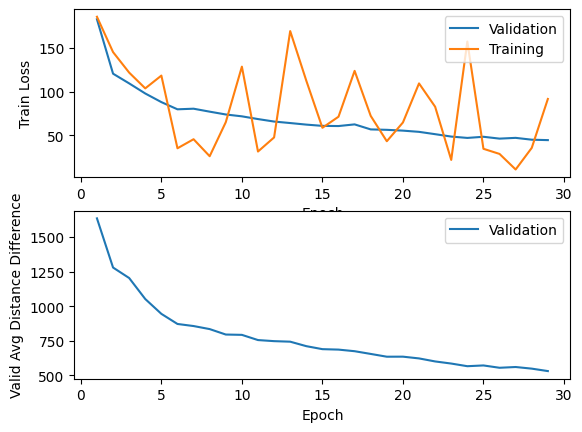

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2)
# this locator puts ticks at regular intervals

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Valid MSE Loss")
ax[0].plot(range(1,len(valid_loss_array)), valid_loss_array[1:], label="Validation") #start from 1 since epoch 0 had a very large mse

ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Valid Avg Distance Difference")
ax[1].plot(range(1, len(valid_acc_array)),valid_acc_array[1:], label="Validation")

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Train Loss")
ax[0].plot(range(1, len(train_loss_array)), train_loss_array[1:], label="Training")

ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

In [2]:
test_loss, test_acc = evaluate_on_data(model, validDataLoader)
print(f"Test Loss: {test_loss}, Test ACC: {test_acc}")

Test Loss: 43.336779778031094, Test ACC: 522.541668434077
